### ref
- ゼロから作るDeep Learning
- pytorch.org

# パーセプトロン・活性化関数・誤差関数・誤差逆伝播
## パーセプトロン
パーセプトロンはニューラルネットワークの元となったモデルで、入力と出力のみからなるモデルです。
このパーセプトロンはNANDすら解けない程度でした。パーセプトロンの関数としての問題は、**線形**であったことです。
> 線形関数は、
   - $c f(x) = f(cx)$ c: 定数
   - $f(x) + f(y) = f(x + y)$   
が成り立つような関数です。

線形だと下のセルにある図1のような問題を解けません。図1にあるような問題を線形分離不可能と言います。
このような問題は複数の直線か曲線でないと分離できません。一方、
線形分離可能な問題というのはクラスタを直線で分離できるようなものです（fig 2.）。
![fig 1](./images/fig_01.png)
![fig 2](./images/fig_02.png)

## 活性化関数
ニューラルネットワークは非線形な関数ですが、シンプルには線形な関数を非線形にするために活性化関数を用います。
活性化関数を適用する位置はスライド参照。  
活性化関数はニューロンの発火にインスパイアされたもので、初めはステップ関数が使われていましたが、誤差を用いたパラメータ更新（学習）のことを
考えて、微分可能な`sigmoid`関数が用いられるようになりました。現在では`ReLU`やその派生が主流になっています。
`ReLU`が主流になっている理由としては、計算が速いことと微分が楽なことが挙げられます。  
ほとんどの問題で、「線形変換によってデータの次元数を減らし、活性化関数を適用する」と言う処理を繰り返して出力します。
![fig 3](./images/fig_03.png)
![fig 4](./images/fig_04.png)
![fig 5](./images/fig_05.png)
![fig 6](./images/fig_06.png)

## 誤差関数
誤差関数は各タスクに合わせて設計されます。回帰問題では二乗誤差、識別問題では交差エントロピー（sigmoid cross entropy、softmax cross entropy）
が主流です。  
モデルの出力を$\hat{\boldsymbol{y}}$、正解を$\boldsymbol{y}$とすると、
二乗誤差は、$|| \boldsymbol{y} - \hat{\boldsymbol{y}}||^2$、交差エントロピーは$ - \boldsymbol{y}\cdot \log \hat{\boldsymbol{y}}$
で計算できます。
表記に関しては誤差の値自体は$\bf{E}$、誤差関数は$L(\hat{\boldsymbol{y}}, \boldsymbol{y}), \ L$と表すことが多いです。

![fig 7](./images/fig_07.png)

普通、誤差は小さいほど良いです。　ただし、前回（4/16）に伝えた通り誤差は2種類あります。前回は図をお見せすることが
できませんでしたが、下の図（青が訓練誤差、オレンジが汎化誤差を表す）[^1]では実際に初めは2つの誤差が
順調に下がっていますが10epochあたりを境に汎化誤差は上がり始めています。そのため、このモデルは100epoch学習したもの
よりも10epochあたりのものの方が道のデータに対して精度が高いと想像できます。

![overfitting](https://github.com/mitmul/chainer-handson/blob/master/DeepCNN_cifar10_result/loss.png?raw=true)

[^1]: image from https://github.com/mitmul/chainer-handson

## 誤差逆伝播
偏微分・連鎖律がベースになっています。実際に扱う場合はフレームワークがよしなにやってくれているので特に説明しません。
この誤差逆伝播で各レイヤーに誤差を渡し、その誤差を用いてパラメータを更新します。

ここでは、PyTorchを用いて（toy dataで）誤差逆伝播をほぼ意識することなく実行できることを
以下のコードを直下のセルにコピペして確認しましょう。`ctrl + b -> cmd + p -> shift + return`

```back_prop_check.py
import torch
from torch.autograd import Variable

x = Variable(torch.ones(2, 2), requires_grad=True)
z = (x + 2) * (x + 2) * 3
print('z: {}'.format(z))
out = z.mean()
print('out: {}'.format(out))
out.backward()
print(x.grad)
```

---

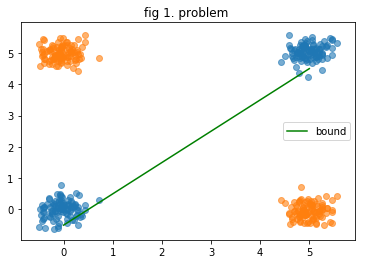

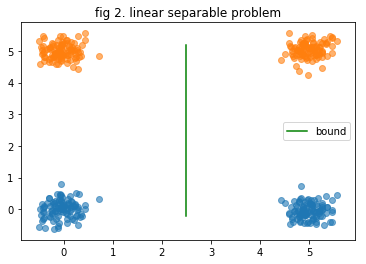

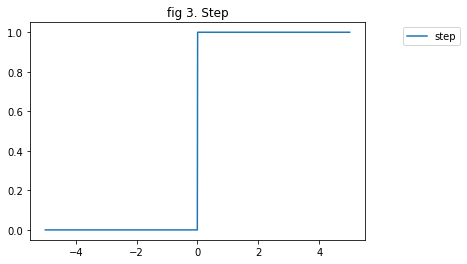

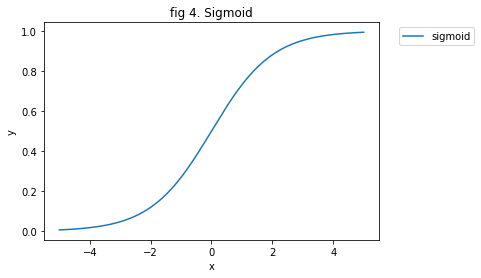

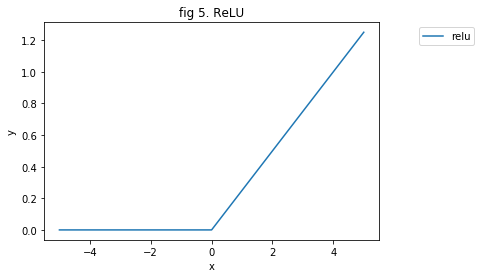

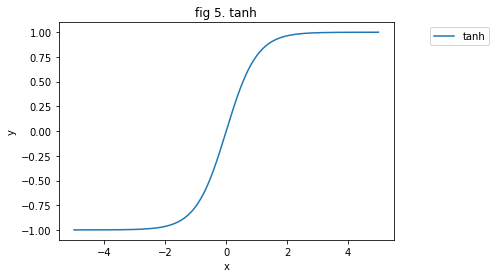

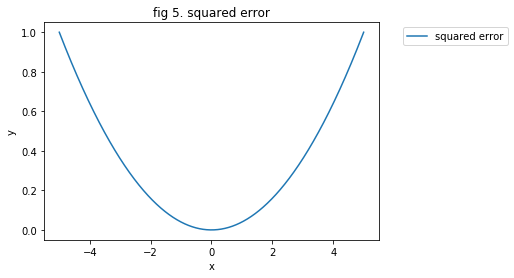

In [1]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt

def gen_random(loc, size):
    return list(np.random.normal(loc=loc, scale=0.25, size=size))

# fig 1
x0, x5, x00, x55 = gen_random(0.0, 100), gen_random(5.0, 100), gen_random(0.0, 100), gen_random(5.0, 100)
a_x = x0 + x5
a_y = x00 + x55
b_x = x5 + x0
b_y = x0 + x5
x= np.linspace(0.0, 5.0, 100)
y = x - 0.5
group_a = plt.scatter(a_x, a_y, alpha=0.6)
group_b = plt.scatter(b_x, b_y, alpha=0.6)
plt.plot(x, y, 'g', label='bound')
plt.legend((group_a, group_b), ('group A', 'group B'), bbox_to_anchor=(1.3, 1))
plt.legend()
plt.title('fig 1. problem ')
plt.show()
plt.close('all')

# fig 2
a_x = x0 + x5
a_y = x00 + x0
b_x = x5 + x0
b_y = x55 + x5
x = [2.5] * 100
y = np.linspace(-0.2, 5.2, 100)
group_a = plt.scatter(a_x, a_y, alpha=0.6)
group_b = plt.scatter(b_x, b_y, alpha=0.6)
plt.plot(x, y, 'g', label='bound')
plt.legend((group_a, group_b), ('group A', 'group B'), bbox_to_anchor=(1.3, 1))
plt.legend()
plt.title('fig 2. linear separable problem')
plt.show()
plt.close('all')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def step(x):
    tmp = x > 0
    return tmp.astype(int)

def relu(x):
    return np.minimum(np.maximum(0.25 * x, 0), 6)

x = np.linspace(-5, 5, 1000)
y1 = sigmoid(x)
y2 = step(x)
y3 = relu(x)
y4 = np.tanh(x)
y5 = x * x / 25.0
plt.plot(x, y2, label='step')
plt.title('fig 3. Step')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()
plt.close('all')
plt.plot(x, y1, label='sigmoid')
plt.xlabel('x')
plt.ylabel('y')
plt.title('fig 4. Sigmoid')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()
plt.close('all')
plt.plot(x, y3, label='relu')
plt.xlabel('x')
plt.ylabel('y')
plt.title('fig 5. ReLU')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()
plt.close('all')
plt.plot(x, y4, label='tanh')
plt.xlabel('x')
plt.ylabel('y')
plt.title('fig 5. tanh')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()
plt.close('all')
plt.plot(x, y5, label='squared error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('fig 5. squared error')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()
plt.close('all')

# ニューラルネット
## 学習の流れ

### ミニバッチ
データセットの大きさを$N$とするとデータセットは教師あり学習の場合は$(\boldsymbol{x}_i, \boldsymbol{y}_i)_{i= 1}^N$と表せます。
バッチ処理はデータセットのすべてのデータに対して誤差を計算し、パラメータを更新する方法ですが、$N = 10,000$を超えることがほとんどの場合、
誤差を計算する回数に対してアップデートの回数が少なく、学習に時間がかかります。そのため、一般的には$n = 32$ぐらいのデータ（ミニバッチ）ごとに
アップデートを行い、プログラム中ではミニバッチを1つの変数のように扱います。
データの次元数が$d_{data}$の時、ミニバッチの形はは$n \times d_{data}$になります。

よく、「学習は100epochで1epochは300iteration」などの言い方をしますが、
データセットの大きさを$N$、ミニバッチの大きさを$n$とすると、イテレーション数は$N / n$となり、これが1epochに該当します。

<!--
## 実装
コードを書いていきましょう。
-->

## データの扱い方
ミニバッチを1つの変数として扱うので学習ループ内での各変数の形は`[batch_size, *data_shape]`になります。

## モデルの構造
モデルはレイヤー（線形変換）と活性化関数（非線形）で作られていますが、どちらも関数であることに変わりはないです。しかし、
レイヤーは重みが更新されるので学習するにつれてその出力は変化します。`モデルの構造 1`では箱と箱を結ぶ線が活性化関数を、箱自体がレイヤーを表しています。また、`モデルの構造 2`では活性化関数が省略されています。  
多くのライブラリではレイヤーと活性化関数のファイルのディレクトリが分けられています。

###  レイヤー
- Linear / Dense / Full Connected
- Convolutional
- Recurrent (LSTM)
- Normalisation
    - (Dropout)
    - Batch Normalization
    
### 活性化関数
- tanh
- sigmoid
- relu
    - leaky relu
    - prelu
    - elu
    
## 多層パーセプトロン（Multi Layer Perceptron）
### どんなモデルか
多層パーセプトロンは`Linear~`レイヤーのみからなるニューラルネットワークで、データの行列と重みの行列のかけ算を繰り返して
います。
基本的に、このレイヤーを用いた計算を行う場合、入力として渡せるデータは2次元配列で、axis-0がバッチサイズ、axis-1が
データの特徴量の次元数です。レイヤーの定義をする際に、`Linear`レイヤーに入力するときのデータの特徴量の次元数`in_size`と出力する際のデータの特徴量の次元数`out_size`を指定します。`in_size`はその前のレイヤーの`out_size`、あるいはもともとのデータの特徴量の次元数に揃える必要がありますが、`out_size`は任意の値を指定できます。

![linear](./images/linear_layer.png)

---

ここでは、まず有名な手書き数字データセットのMNISTを用いて多層パーセプトロンの実験を行います。
多層パーセプトロン（スライド参照）を実装しましょう。
MNISTのデータは$0$から$9$の10クラス分類で各データは$28 \times 28$の画像を平らにした$784$次元です。
この$784$次元のデータをいくつかの`Linear`を用いて$10$次元にしましょう。
ここで使えるレイヤーは

- `Linear`: 第1引数：入力データの次元数、第2引数：出力データの次元数
- `BatchNorm1d`: 引数は次元数
- `Dropout`: 引数は変数

で、活性化関数は

- `sigmoid`
- `relu`
- `tanh`

などです。

`import`する必要があるのは、

```mnit_mlp.py
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
import chainer
from chainer import datasets

In [6]:
mnist = datasets.get_mnist()

In [14]:
import numpy as np
print(type(mnist))
print(len(mnist))
print(type(mnist))
print(len(mnist[0]))
print(len(mnist[0][0]))

<class 'tuple'>
2
<class 'tuple'>
60000
2


In [13]:
train, test = mnist

In [8]:
import pickle

In [9]:
with open('./mnist.pkl', 'w') as f:
    pickle.dump(mnist, f)

TypeError: write() argument must be str, not bytes